In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [5]:
"""
Tutorial: Customer Segmentation using K-Means Clustering on Mall Customers Dataset

Overview:
This tutorial demonstrates how to segment customers based on demographic and spending behaviors
using K-Means clustering. We use the Mall Customers dataset which contains features such as Age,
Annual Income, and Spending Score. The tutorial covers data exploration, preprocessing, cluster
analysis (including elbow and silhouette methods), and visualization of the clustering results.
"""

# Set a fresh plotting style
plt.style.use("fivethirtyeight")
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (10, 6)


In [6]:
# 1. Data Loading and Exploration
# Load the Mall Customers dataset (ensure 'Mall_Customers.csv' is in the working directory)
df = pd.read_csv("/content/Mall_Customers.csv")

print("Dataset Shape:", df.shape)
print("\nDataset Preview:")
df.head()


Dataset Shape: (200, 5)

Dataset Preview:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
print("\nData Info:")
df.info()



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [8]:
# 2. Data Preprocessing
# We will focus on the numeric features: Age, Annual Income, Spending Score
# Optionally, we can encode Gender to include it in clustering. Here, we use:
#   - 'Age'
#   - 'Annual Income (k$)'
#   - 'Spending Score (1-100)'
# For demonstration, we'll exclude CustomerID and ignore Gender.
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
data = df[features].copy()

# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())


Missing values per column:
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [9]:
# Scale features for K-Means clustering (important for distance-based methods)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)
X_scaled = pd.DataFrame(X_scaled, columns=features)


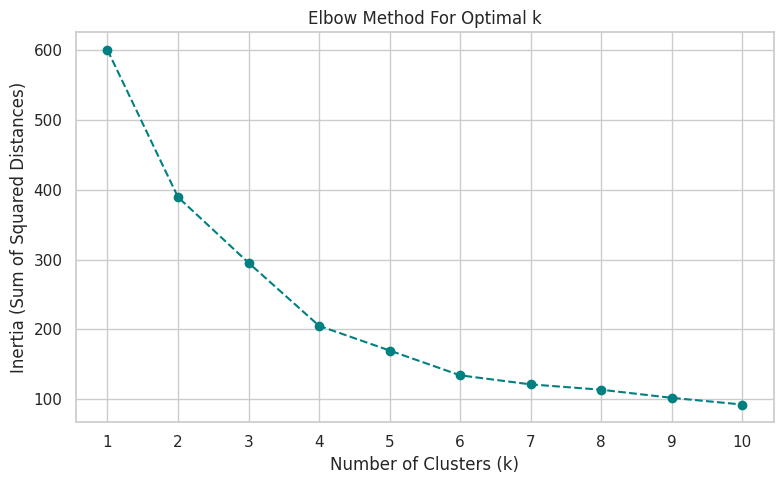

In [10]:
# 3. Determining the Optimal Number of Clusters
# Use the Elbow method: plot inertia for a range of cluster numbers
inertia_values = []
cluster_range = range(1, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--', color='teal')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method For Optimal k")
plt.xticks(cluster_range)
plt.tight_layout()
plt.show()


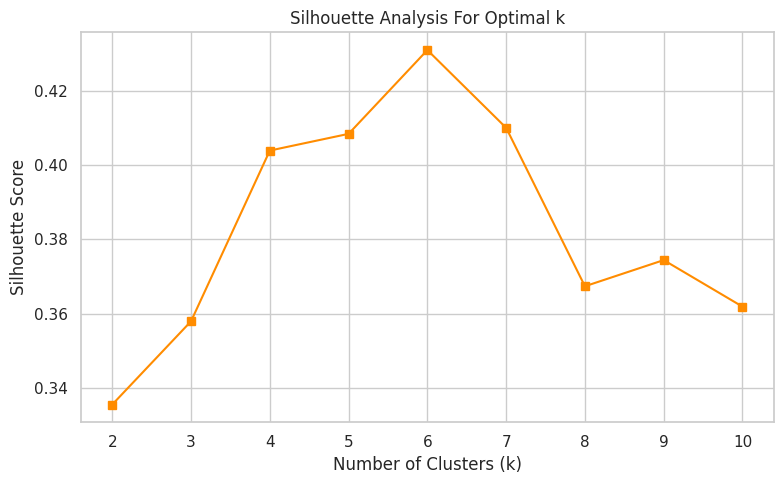

In [11]:
# Use silhouette score to further confirm optimal k (we skip k=1)
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='s', linestyle='-', color='darkorange')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis For Optimal k")
plt.xticks(range(2, 11))
plt.tight_layout()
plt.show()


In [13]:
# Based on the plots, we decide to use k = 5 (a common choice for the Mall Customers dataset)
optimal_k = 5

# 4. Applying K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['Cluster'] = clusters
print("\nCluster counts:")
print(df['Cluster'].value_counts())



Cluster counts:
Cluster
0    58
3    45
1    40
4    31
2    26
Name: count, dtype: int64


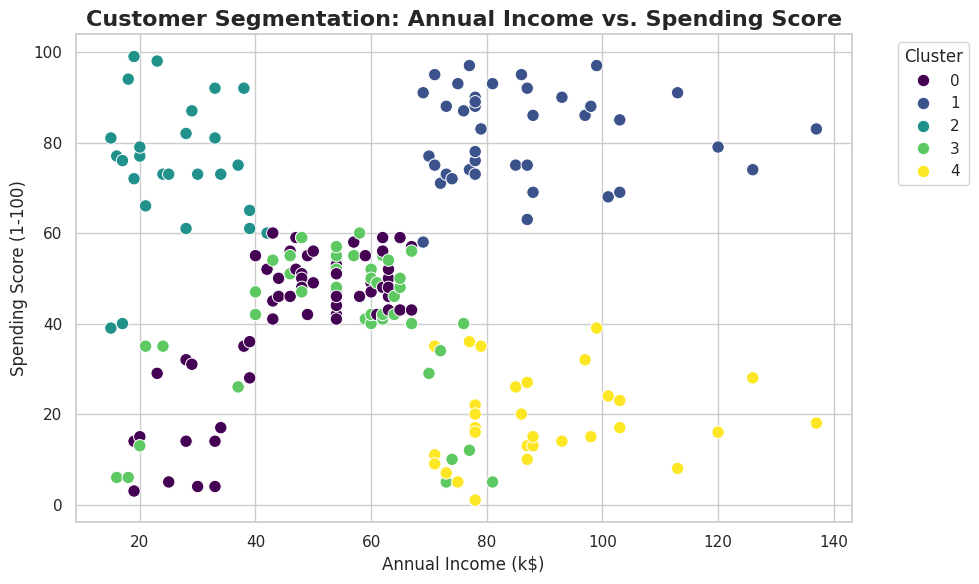

In [14]:
# 5. Visualizing the Clusters
# 5.1. Scatter Plot: Annual Income vs. Spending Score, colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='viridis', s=80)
plt.title("Customer Segmentation: Annual Income vs. Spending Score", fontsize=16, weight='bold')
plt.xlabel("Annual Income (k$)", fontsize=12)
plt.ylabel("Spending Score (1-100)", fontsize=12)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [16]:
# 5.2. Radar Chart for Cluster Centers
# Retrieve cluster centers from the KMeans model (in scaled space)
centers = kmeans.cluster_centers_
# Inverse transform to original scale
centers_original = scaler.inverse_transform(centers)
centers_df = pd.DataFrame(centers_original, columns=features)
print("\nCluster Centers (Original Scale):")
centers_df



Cluster Centers (Original Scale):


,Age,Annual Income (k$),Spending Score (1-100)
0,55.275862,47.620690,41.706897
1,32.875000,86.100000,81.525000
2,25.769231,26.115385,74.846154
3,26.733333,54.311111,40.911111
4,44.387097,89.774194,18.483871


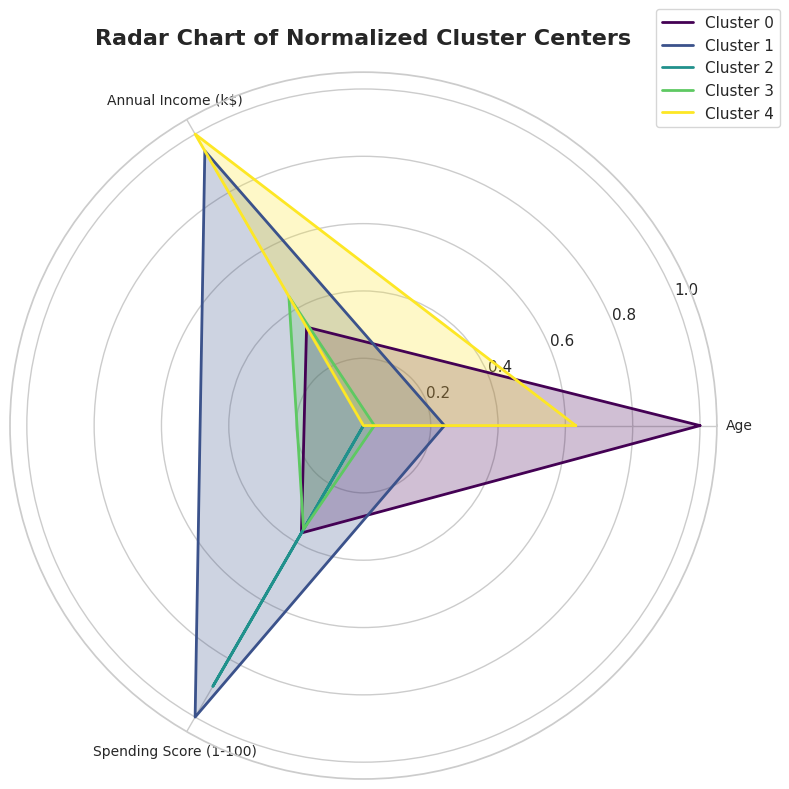

In [17]:
# For radar chart, we need to normalize centers for plotting (0-1 scale per feature)
normalized_centers = centers_df.copy()
for col in features:
    normalized_centers[col] = (centers_df[col] - centers_df[col].min()) / (centers_df[col].max() - centers_df[col].min())

# Plot radar chart for each cluster in a loop
import matplotlib.cm as cm
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]  # complete the circle

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))
colors = cm.viridis(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    values = normalized_centers.iloc[i].tolist()
    values += values[:1]  # complete circle
    ax.plot(angles, values, label=f'Cluster {i}', color=colors[i], linewidth=2)
    ax.fill(angles, values, alpha=0.25, color=colors[i])

ax.set_thetagrids(np.degrees(angles[:-1]), features, fontsize=10)
ax.set_title("Radar Chart of Normalized Cluster Centers", fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()

<ipython-input-18-c36eeb62faa7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


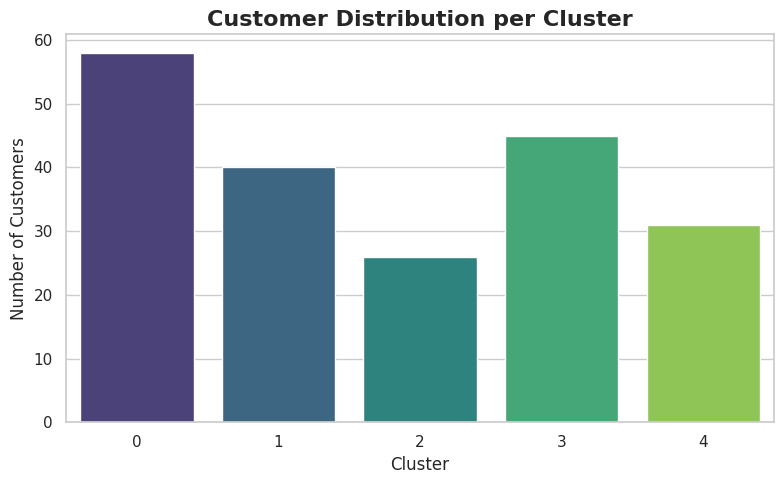

In [18]:
# 5.3. Bar Chart: Distribution of Customers per Cluster
cluster_counts = df['Cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution per Cluster", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

In [19]:
# 6. Additional Visualizations for Teaching and Interpretation
# 6.1. Interactive Plotly Scatter Plot (3D) of Clusters using Age, Annual Income, and Spending Score
fig_3d = px.scatter_3d(
    df,
    x='Age',
    y='Annual Income (k$)',
    z='Spending Score (1-100)',
    color='Cluster',
    title="3D Scatter Plot of Customer Segments",
    labels={
        "Age": "Age",
        "Annual Income (k$)": "Annual Income (k$)",
        "Spending Score (1-100)": "Spending Score"
    }
)
fig_3d.show()

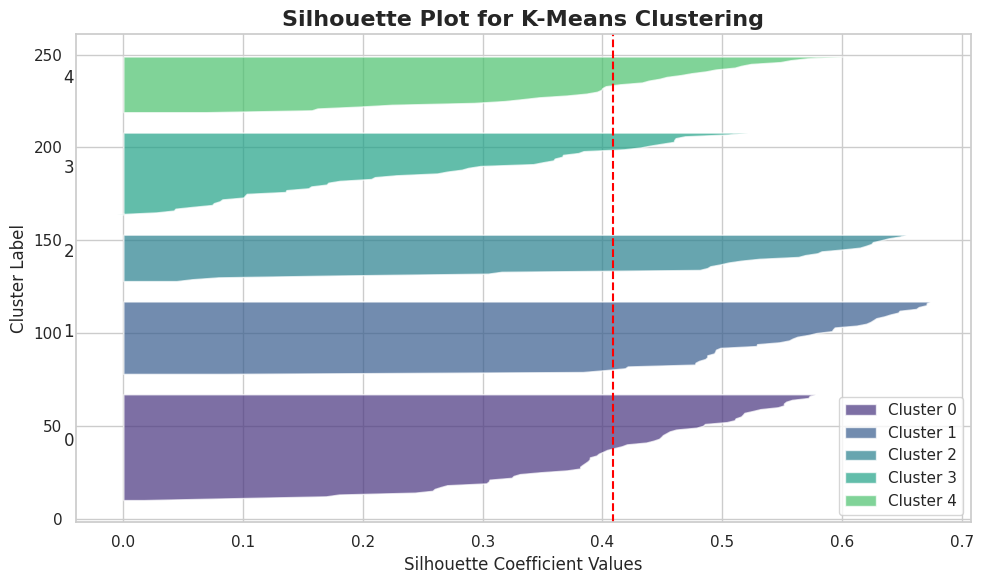

In [20]:
# 6.2. Silhouette Plot to Evaluate Cluster Quality
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(X_scaled, clusters)

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(optimal_k):
    ith_cluster_silhouette_vals = silhouette_vals[clusters == i]
    ith_cluster_silhouette_vals.sort()
    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_vals,
                      alpha=0.7, label=f'Cluster {i}')
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for spacing

plt.xlabel("Silhouette Coefficient Values", fontsize=12)
plt.ylabel("Cluster Label", fontsize=12)
plt.title("Silhouette Plot for K-Means Clustering", fontsize=16, fontweight='bold')
plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()